In [92]:
import chess.pgn
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry_convert
from geopy.geocoders import Nominatim
import folium
import cartopy.crs as ccrs
import cartopy
from tqdm import tqdm

In [83]:
pgn = open("caissabase.pgn") # DB containing ~4 million chess games

## Visualization 4: World & EU Maps of Chess Games

<br>
The code in the next 2 cells is adapted from https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10.

```get_country_continent()``` takes an alpha3 country code and converts it to an alpha2 country code according to the ISO3266 standard. This is done as an intermediate step for obtaining the continent code, which is useful when plotting a world map. The function returns the alpha2 country code and continent code.

```geolocator()``` takes an alpha2 country code, returning the corresponding latitude and longitude for the country's **centre**. N.B. the Nominatim module used in this function is unable to give coordinates for India (alpha2 code _IN_) for some unknown reason. This may be the case for a **few** other countries. 

In [77]:
def get_country_continent(a3):
    try: # try to convert alpha3 country code to alpha2
        a2_code = pycountry_convert.country_alpha3_to_country_alpha2(a3)
    except: # if country code is not alpha3 or otherwise invalid 
        if a3 == "GER": return get_country_continent("DEU")
        if a3 == "NED": return get_country_continent("NLD")   
        if a3 == "POR": return get_country_continent("PRT")
        if a3 == "SCO": return get_country_continent("GBR")
        if a3 == "ENG": return get_country_continent("GBR")
        if a3 == "IRE": return get_country_continent("GBR")
        a2_code = "Unknown"
    try: # try to retrieve continent code for alpha2 country code
        continent = pycountry_convert.country_alpha2_to_continent_code(a2_code)
    except: # continent not found?
        continent = "Unknown"
    
    return(a2_code, continent)

In [78]:
geolocator = Nominatim(user_agent="myGeocoder")
def geolocate(country):
    try:
        # geolocate center of country
        loc = geolocator.geocode(country)
        # return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # return numpy nan
        return np.nan

  1%|          | 50000/4270000 [00:27<38:16, 1837.53it/s]  


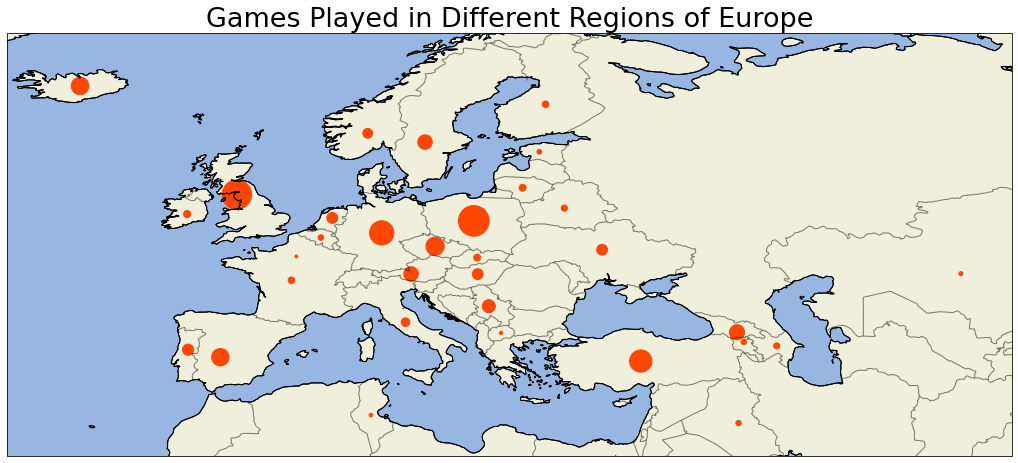

In [96]:
locations = [] # stores country codes
regex = r"\b[A-Z]{3}\b" # regex pattern to match country codes
res = re.compile(regex)
pbar = tqdm(total=4270000) # set up progress bar

# skim through headers
for i in range(0,50000):
    offset = pgn.tell()
    headers = chess.pgn.read_headers(pgn)
    
    # if reached end
    if headers is None:
        break 
        
    try: # append alpha 3 country code to locations list
        locations.append(res.findall(headers.get("Site")))
    except: # skip country code on malformed header
        continue      
    pbar.update(1) # update progress bar
    
pbar.close() # close progress bar

# flatten list of lists to 1D list
flat_list = [item for sublist in locations for item in sublist]

#------------------------------------------------------------------------------------------
country_continent = [] # stores country and continent codes

for i in flat_list:
    country_continent.append(get_country_continent(i))
    
d = collections.Counter(country_continent)
d = collections.OrderedDict(sorted(d.items()))

#------------------------------------------------------------------------------------------
s = pd.Series(d)
geo_df = pd.DataFrame(d.items(), columns=["Location", "Games"])
geo_df

#------------------------------------------------------------------------------------------
country_coords = []
for i in range(len(geo_df.Location)):
    country_coords.append(geolocate(geo_df.Location[i][0]))

lats = []
longs = []
for coord in country_coords:
    if(isinstance(coord, float) is False):
        lats.append(coord[0])
        longs.append(coord[1])
    else:
        lats.append(28.644800)
        longs.append(77.216721)

geo_df["Latitude"] = lats
geo_df["Longitude"] = longs


#------------------------------------------------------------------------------------------
# remove all unknown countries/games
for i in range(len(geo_df)):
    if (geo_df.iloc[i][0][0] == "Unknown"):
#     if (geo_df.iloc[i][0] == "Unknown"):
        geo_df = geo_df.drop(index=i)
geo_df

In [81]:
# set up and plot Europe map
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
# closeup of Europe
ax.set_extent([-25, 70, 30, 70], crs=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution = '50m')

plt.scatter(x=geo_df.Longitude, y=geo_df.Latitude,
            color="orangered",
            s=geo_df.Games / 5,
            alpha=0.99)
plt.title("Games Played in Different Regions of Europe", fontsize="27")
plt.savefig('fig/EU Map.png')
plt.show()

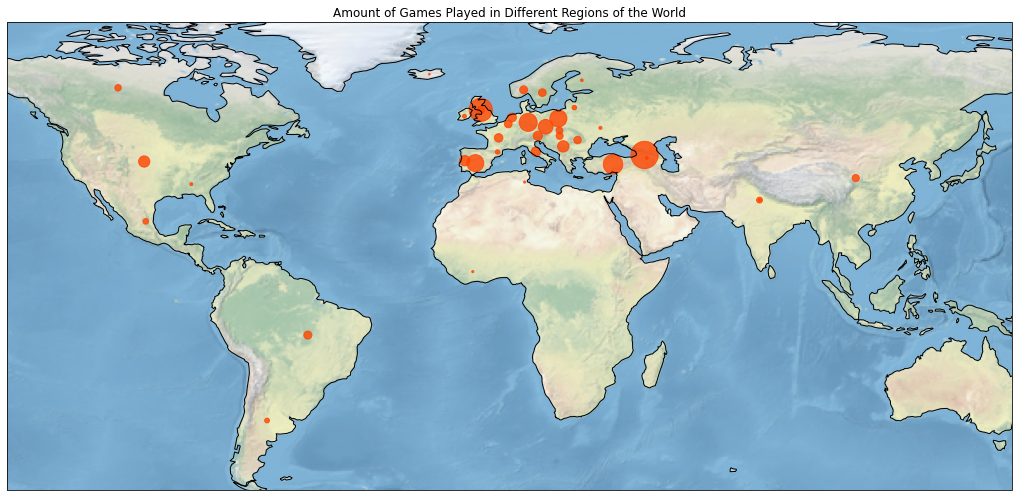

In [85]:
# set up and plot world map
fig = plt.figure(figsize=(18,20))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

# full map of the world
ax.set_extent([-140, 150, -55, 80], crs=ccrs.PlateCarree()) 

ax.stock_img()
ax.coastlines()

plt.scatter(x=geo_df.Longitude, y=geo_df.Latitude,
            color="orangered",
            s=geo_df.Games / 10,
            alpha=0.8)
plt.title("Amount of Games Played in Different Regions of the World")
plt.show()